In [27]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms


In [28]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

print 20 // 10

2


In [29]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=False, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=False, transform=transform)

In [30]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [31]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [32]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64) #4608 input features, 64 output features  
        self.fc2 = torch.nn.Linear(64, 10) #64 input features, 10 output features 
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x)) #Size changes from (3, 32, 32) to (18, 32, 32)
        x = self.pool(x) #Size changes from (18, 32, 32) to (18, 16, 16)
        x = x.view(-1,18*16*16)  #Size changes from (18, 16, 16) to (1, 4608)
        x = F.relu(self.fc1(x)) #Size changes from (1, 4608) to (1, 64)
        x = self.fc2(x) #Size changes from (1, 64) to (1, 10)
        return x

In [80]:
 
def outputSize(in_size,kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return output
    
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,num_workers=2)
    return train_loader

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

def createLossAndOptimizer(net, learning_rate=0.01):  
    loss = torch.nn.CrossEntropyLoss() #Loss function
    optimizer = optim.Adam(net.parameters(),lr=learning_rate) #Optimizer
    return loss, optimizer
    
    
def training(net, batch_size, n_epochs, learning_rate):
        # Print all the hyperparameters
        print '-'*10 + 'HYPER-PARAMETERS' + '-'*10
        print 'Batch_size=' + str(batch_size) + ', Epochs=' + str(n_epochs) + ', Learning_Rate=' + str(learning_rate)
        
        #Get Trainig Data
        train_loader = get_train_loader(batch_size)
        n_batches = len(train_loader)
        
        #Creating loss and optimizer
        loss, optimizer = createLossAndOptimizer(net, learning_rate)
        
        # Start Time
        training_start_time = time.time()
        print 'Trainning Start Time:' + str(training_start_time)
        
        # Loop for n_epochs
        for epoch in range(n_epochs):
            
            running_loss = 0.0
            print_every = n_batches / 10
            start_time = time.time()
            total_train_loss = 0.0
            
            for i, data in enumerate(train_loader,0):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                
                #Set the parameter gradients to 0,To clean gradients that might be left in buffer 
                optimizer.zero_grad() 
                
                #print inputs.size() 
                # Forward, Backward, Optimize
                outputs = net(inputs)
                loss_size = loss(outputs, labels)
                loss_size.backward()
                optimizer.step()
                
                # Print Statistics
                running_loss += loss_size.data[0]
                total_train_loss += loss_size.data[0]
                
                # Print every 10th batch of an epoch
                if (i+1) % (print_every+1) == 0:
                    print 'Epoch: ' + str(epoch+1)
                    print ' What is this? ' + str(100*(i+1)/n_batches)
                    print 'Train Loss ' + str(running_loss)
                    print 'Time Taken ' + str(time.time() - start_time)
                    running_loss = 0.0
                    start_time = time.time()
                
        # Do a pass on validation set 
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #wrap tensor in variables
            inputs, labels  = Variable(inputs), Variable(labels)
            
            #Forward Pass 
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
        
        print 'Validation loss: ' + str(total_val_loss / len(val_loader))
        print 'Training Finished, Time Taken: ' + str(time.time() - training_start_time)

In [45]:
CNN = SimpleCNN()
training(CNN, batch_size=32, n_epochs=1, learning_rate=0.001)

----------HYPER-PARAMETERS----------
Batch_size=32, Epochs=1, Learning_Rate=0.001
Trainning Start Time:1531124246.52


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1
 What is this? 10
Train Loss tensor(65.3550)
Time Taken 3.6514518261
Epoch: 1
 What is this? 20
Train Loss tensor(63.0640)
Time Taken 3.59728717804
Epoch: 1
 What is this? 30
Train Loss tensor(64.6717)
Time Taken 3.91452789307
Epoch: 1
 What is this? 40
Train Loss tensor(68.2900)
Time Taken 3.41613888741
Epoch: 1
 What is this? 50
Train Loss tensor(65.6449)
Time Taken 3.2998418808
Epoch: 1
 What is this? 60
Train Loss tensor(65.2853)
Time Taken 3.2302479744
Epoch: 1
 What is this? 70
Train Loss tensor(66.4568)
Time Taken 3.24578881264
Epoch: 1
 What is this? 80
Train Loss tensor(63.7955)
Time Taken 3.77501988411
Epoch: 1
 What is this? 90
Train Loss tensor(64.1204)
Time Taken 3.64997696877


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:80: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss: tensor(1.1648)
Training Finished, Time Taken: 38.7686150074


In [81]:
# Testing 
for inputs, labels in test_loader:
    inputs, labels = Variable(inputs), Variable(labels)
    test_out = CNN(torch.FloatTensor(inputs))
    outs = test_out.data.numpy().argmax(axis=1)
    y_test = labels.data.numpy()
    #accuracy = (test_outputs == labels).sum()*100 / labels.shape

print outs
print y_test
accuracy = (outs == y_test).sum()*100.0 / y_test.shape[0] 
print str(accuracy) + '%'

# WHY are the number of samples equal to batch size in this????????

[2 0 9 5 1 8 4 7 0 0 2 9 7 6 4 5 9 1 7 4 0 8 9 1 6 5 6 3 1 3 6 5 4 0 9 9 7
 4 3 8 1 4 6 0 4 0 6 2 4 3 3 7 0 9 1 2 3 9 0 0 7 0 0 8 4 5 1 6 8 9 9 3 0 5
 2 7 6 1 2 0 3 3 7 6 3 7 9 4 4 9 8 9 6 2 3 6 3 9 2 0 4 4 3 5 2 0 4 4 5 9 2
 7 6 3 0 8 9 6 0 3 3 3 1 7 0 4 8 1 3 4 3 6 4 3 7 2 4 8 0 0 1 3 3 0 9 6 9 4
 9 4 5 3 2 3 3 8 2 7 0 3 4 6 1 2 0 3 1 3 7 6 6 6 8 1 9 3 1 9 3 8 3 3 0 4 4
 7 0 2 1 8 7 5 3 9 8 6 6 5 1 2 2 1 3 4 4 4 2 3 8 1 4 0 8 8 0 4 9 2 5 7 2 7
 4 1 3 3 0 4 8 8 8 8 5 8 6 1 6 4 1 9 3 3 7 9 5 1 4 1 4 1 9 8 9 1 9 9 1 1 1
 9 2 6 0 5 9 1 4 0 1 1 7 9 9 4 9 1 7 4 6 9 5 1 7 0 6 2 4 8 8 9 9 8 0 0 1 8
 1 8 2 0 0 1 3 4 0 8 2 0 9 0 9 3 6 6 0 6 3 2 1 6 7 1 3 4 3 1 9 3 2 3 3 6 1
 8 8 1 1 5 6 0 8 6 1 9 0 2 8 9 8 0 9 6 8 3 1 4 8 3 9 5 3 2 1 7 1 0 9 9 3 5
 9 4 0 6 6 0 6 5 4 8 3 2 4 7 1 5 3 5 6 0 0 7 2 1 7 1 4 6 3 4 0 8 1 5 9 2 5
 2 0 4 4 4 2 8 1 1 1 1 1 1 9 0 4 1 3 1 8 6 4 5 3 1 2 6 5 4 4 6 8 3 6 3 3 3
 0 0 7 0 8 3 0 8 3 1 1 1 1 1 3 9 5 2 1 9 9 3 4 3 6 6 7 9 0 7 5 4 0 8 1 4 2
 1 3 6 7 7 0 4 0 8 6 6 9 

['conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']
torch.Size([18, 3, 3, 3])


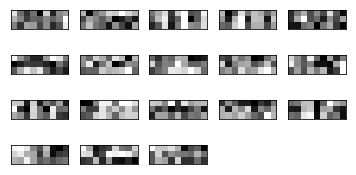

In [82]:
# AFTER CNN
import matplotlib.pyplot as plt

print CNN.state_dict().keys()

conv_01 = CNN.state_dict()['conv1.weight']
print conv_01.size()

plt.figure(0)
for ix in range(conv_01.shape[0]):
    plt.subplot(5, 5, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv_01[ix].reshape((3,9)), cmap='gray')
plt.show()

# What are these exactly??????

In [ ]:
# Convolutional Neural Networks

# These are just activations of clusters percieved by eyes
# Kerchevky's ImageNet paper
# CNN have local connections, layering and spatial invariance
# invariance is achieved by pooling 

# input --> feature learning --> classification
# feature learning => convolution + relu --> pooling
# classification => flatten --> fully connected --> softmax

# dropout paper hinton (ovrefitting)
# randomly picks neurons and sets the value to 0 so that the nn is learn from new paths
# Andrey karpati cnn

# use cnn when there is spatial variance for example if 2 columns are 
# swapped in position then it chnages data. use nn only at that time

# Can build a custom filter also
# Filter 1 = Sharpen
#  0 -1   0
# -1  5  -1
#  0 -1   0

# Filter 2 = Blur
# 1 1 1 
# 1 1 1 
# 1 1 1 


# Filter 3 = Edge Enhance
#  0 0 0 
# -1 1 0 
#  0 0 0

# Filter 4 = Edge Detect
#  0  1  0
#  1 -4  1
# -0  1  0

# It's not fully connected network 
# At each layer it goes to higher level of detection 
# eg. raw-pixels --> edges --> shapes --> facial shapes

# Plotly install and implement but it's computationally exhaustive